# Demo notebook for Kamodo's Constellation: Spherical Coordinates
This notebook tutorial shows how to fly a constellation of satellites through model data as a virtual reality, focusing on spherical coordinate examples. Trajectories can be obtained either from the test GDC trajectory file or the flythrough trajectory functions. The GDC test trajectory was designed to be approximately stationary in GSE coordinates. See the Trajectory_Coord_Plots demo notebook for examples on flythrough trajectory options.

In [1]:
# Get trajectory data from an old GDC trajectory file. 
from kamodo_ccmc.tools.constellation import read_GDC_sattraj, Constellation

file_dict = read_GDC_sattraj('C:/Users/rringuet/Kamodo_Jan2023/Kamodo/docs/notebooks/KGS_orbit_data.txt')
# coordinates in GDZ spherical: 'UTCtimestamps' in s, 'Longitude' in deg, 'Latitude' in deg, 'Altitude' in km
print(file_dict['UTCtimestamps'].min(), file_dict['UTCtimestamps'].max())  # min and max for later comparison to data

C:\Users\rringuet\Anaconda3\envs\Kamodo_Jan2023\lib\site-packages\spacepy\time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


1552773600.0 1552960800.0


In [2]:
# Find out what models are available.
# The models available through the flythrough are automatically available through the reconstruction function.
from kamodo_ccmc.flythrough import model_wrapper as MW
MW.Choose_Model('')

Possible models are: 
ADELPHI: AMPERE-Derived ELectrodynamic Properties of the High-latitude Ionosphere https://doi.org/10.1029/2020SW002677
AMGeO: Assimilative Mapping of Geospace Observations https://doi.org/10.5281/zenodo.3564914
CTIPe: Coupled Thermosphere Ionosphere Plasmasphere Electrodynamics Model https://doi.org/10.1029/2007SW000364
DTM: The Drag Temperature Model https://doi.org/10.1051/swsc/2015001
GAMERA_GM: Grid Agnostic MHD for Extended Research Applications - Global Magnetosphere outputs https://doi.org/10.3847/1538-4365/ab3a4c (coming soon)
GITM: Global Ionosphere Thermosphere Model https://doi.org/10.1016/j.jastp.2006.01.008
IRI: International Reference Ionosphere Model https://doi.org/10.5194/ars-16-1-2018
OpenGGCM_GM: The Open Geospace General Circulation Model - Global Magnetosphere outputs only https://doi.org/10.1023/A:1014228230714
SuperDARN_uni: SuperDARN uniform grid output https://doi.org/10.1029/2010JA016017
SuperDARN_equ: SuperDARN equal area grid output htt

In [3]:
# For a given model, find out what time range is covered by the data in a given directory.
model = 'GITM'
file_dir = 'D:/GITM/jasoon_shim_071418_IT_1_tenth/'  # change to match your machine
times = MW.File_Times(model, file_dir)
# This function also automatically performs any data preparation needed.

UTC time ranges
------------------------------------------
Start Date: 2015-03-17  Time: 00:00:00
End Date: 2015-03-19  Time: 01:48:59


In [4]:
# Shift times in example trajectory to match model data time range. 
# Some of the trajectory at the end will be automatically excluded later if not covered by the data.
time_diff = file_dict['UTCtimestamps'].min() - 1426550400
file_dict['sat_time'] = file_dict['UTCtimestamps'] - time_diff
print(file_dict['sat_time'].min(), file_dict['sat_time'].max())
# Make sure the data you choose covers at least half the time range of the trajectory.

1426550400.0 1426737600.0


In [5]:
# Convert coordinates to system desired for reconstruction to take place in.
# See Trajectory_Coords_Plots notebook for more details.
from kamodo_ccmc.flythrough.utils import ConvertCoord
coord_type, coord_grid = 'GEO', 'sph'  # choose coordinate system to perform reconstruction in.
c1, c2, c3, units = ConvertCoord(file_dict['sat_time'], file_dict['Longitude'], file_dict['Latitude'], 
                                 file_dict['Altitude'], 'GDZ', 'sph', coord_type, coord_grid)

Converting 37441 positions into GEOsph coordinates...done in 176.1780 seconds.


In [6]:
# Bring up documentation for the reconstruction functionality.
help(Constellation)

Help on class Constellation in module kamodo_ccmc.tools.constellation:

class Constellation(kamodo.kamodo.Kamodo)
 |  Constellation(model, variable_name, file_dir, sat_time, c1, c2, c3, coord_type, coord_grid, recon_option, recon_dims, time_offsets=[0.0], c1_offsets=[0.0], c2_offsets=[0.0], c3_offsets=[0.0], dx=2.0, dy=2.0, d1=0.0, d2=0.0, LT='', t_avg='', c1_avg='', c2_avg='', c3_avg='', dt=60.0, run_option='all', **kwargs)
 |  
 |  Uses shifted copies of the satellite trajectory to reconstruct
 |  the model data for the variable name given. See
 |  https://doi.org/10.22541/essoar.167214257.73153757/v1 for more info.
 |  
 |  - model: 'CTIPe', 'IRI', 'GITM', 'SWMF_IE', 'TIEGCM', etc
 |      (See MW.Choose_Model() output.)
 |  - variable_name = choose from list of standardized variable names from
 |      model chosen
 |  - file_dir = file path to model data
 |  - sat_time: a numpy array of the utc timestamps
 |  - c1, c2, c3: numpy arrays of the positions correlating to the utc
 |     

In [7]:
# Choose inputs.
variable_name = 'T_n'  # from chosen files above
recon_dimensions = 'c1c2'  # Longitude vs Latitude reconstruction for spherical coordinates
recon_option = 'AvgMod_AvgSlice'

# Set up constellation input:
lon_offsets = [0., 30., 60., 90., 120., 150.]  # 6 satellites equally spaced in longitude
#lon_offsets, time_offsets = [0.,-30.,30.], [0.,-300.,300.]  # 9 satellites in a longitude-time grid
#lon_offsets, lat_offsets = [0.,-30.,30.], [0.,-10.,10.]  # 9 satellites in a longitude-latitude grid
print(c2.min(), c2.max())  # make sure latitude offsets won't bring the orbits beyond +/- 90 degrees latitude.
# If choosing height offsets and the height is in R_E, be careful to enter the offsets in R_E and not km.
# The offset lists give the offsets of the imaginary satellites with identical trajectories in the 
#  other dimensions (e.g. height). Offsets in height are also possible, but not popular.
# Note: Make sure to include the offsets chosen in the next block.

# Note: All offsets are combined to create a number of satellites equal to the multiplied length of each offset array.
#   e.g. lon_offset, lat_offset, time_offset = [-10.,0.,10.], [-10.,0.,10.], [-300.,0.,300.]
#   will yield a constellation of 27 satellites spaced as indicated in the offsets.

# Choose the grid resolution of reconstruction. The finer the resolution, the longer the program takes to run and 
#   the more 'holes' you will see in the reconstructed plot. Physically, these should be set to the instrument's 
#   field of view in the units of the input coordinate system (e.g. degrees for longitude and latitude, seconds for
#   time, etc).
dx, dy = 4., 2.  #Since recon_dimensions='c1c2', dx is resolution in longitude, and dy is the resolution in latitude.

-79.99895546166081 79.9989465876552


In [8]:
# Run the reconstruction.
# This process typically takes up to a few minutes, but can take up to ~2 hours or more depending on the amount of data 
#  used, the grid resolution chosen, the reconstruction method chosen, and whether conversion to pressure level is 
#  required. As originally set, the process takes about 30 seconds.
# Make sure to include all desired offsets in this block before executing.

recon = Constellation(model, variable_name, file_dir, file_dict['sat_time'], c1, c2, c3, coord_type, coord_grid,
                      recon_option, recon_dimensions, c1_offsets=lon_offsets, dx=dx, dy=dy)

Average time used for trajectories: 1426644000.0
Average c3 used for trajectories: 1.062714266389773
Performing satellite constellation flythrough for 224646 locations...
Converting 224646 positions into GDZsph coordinates...done in 4.8730 seconds.
Time slice index 156 added from file.
Time slice index 157 added from file.
Time slice index 158 added from file.
Gridding data for LonLat...done in 30.08224s for 8281 gridpoints.

Average t used for model: 1426644000.0
Average c3 used for model: 1.062714266389773
Performing averaged grid flythrough for 8281 locations...
Time slice index 156 added from file.
Time slice index 157 added from file.
Time slice index 158 added from file.
Grid flythrough completed in 2.19190 s.
Reconstruction program complete in 86.17399 s.


In [9]:
# The output of the function is a Kamodo object with all of the default features described in documentation.
# T_n is the reconstructed data from the constellation flythrough. T_n_model is the data from the model in the 
#  method chosen. PercentDiff is the percent difference between the two, calculated using 
#  PercentDiff = (T_n_model - T_n)/T_n_model*100.
recon

{T_n(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA58318>, T_n: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA58318>, T_n_model(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA589D8>, T_n_model: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA589D8>, PercentDiff(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA3C558>, PercentDiff: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x000001445BA3C558>}

In [17]:
# Show the reconstructed plot.
# Note the plots shown are given in the coordinate system associated with the input trajectory.
# Any gaps in the reconstructed plot indicate gaps in the satellite coverage of the plot grid chosen (dx and dy above),
#   and also depend on the constellation arrangement.

# recon.x and recon.y are the x and y grids of the plots.
# Generate a plot for validation
from kamodo_ccmc.tools.plotfunctions import toColor
toColor(recon.plot(T_n=dict(Lon=recon.x, Lat=recon.y)), colorscale="Viridis")

In [18]:
# Show the corresponding model data
toColor(recon.plot(T_n_model=dict(Lon=recon.x, Lat=recon.y)))

In [19]:
# Show the percent difference between the two. A percent difference of zero is an exact match.
# How well the reconstructed plot matches the model plot not only depends on the constellation arrangement,
#  but also on the reconstruction method chosen. The 'AvgMod_...' options typically result in the better
#  matches, but are not physically representative of what the constellation will 'see' in real data because
#  the two non-reconstructed dimensions are ignored in the input satellite trajectory (e.g. an average value 
#  for both height and time are used instead of the full range for a Lon-Lat reconstruction). The unmodified 
#  options ('Unmod_...') are thus recommended as the more physical comparison because the full set of input 
#  trajectory values are used.
toColor(recon.plot(PercentDiff=dict(Lon=recon.x,Lat=recon.y)))

Text(0, 0.5, 'Frequency')

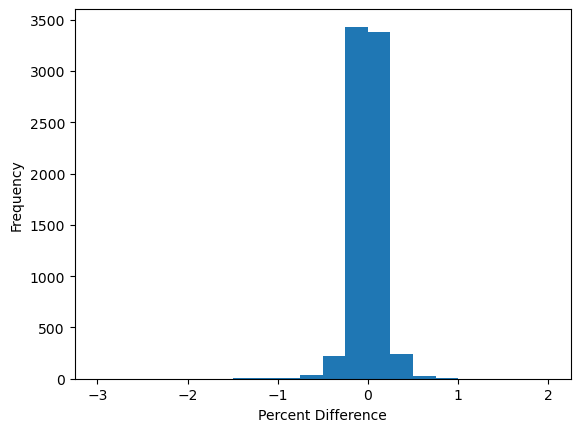

In [16]:
# Retrieve the percent difference data values and show in a histogram, ignoring NaN values.
# Some extra logic is required to automatically enforce bins of width 2%
import numpy as np
import matplotlib.pyplot as plt

pdiff_data = recon.PercentDiff()
data_min, data_max = np.floor(np.nanmin(pdiff_data)), np.ceil(np.nanmax(pdiff_data))
num_bins = int((data_max-data_min)/2.)
if num_bins<5:
    num_bins=20
hist, edges, patches = plt.hist(np.ravel(pdiff_data), range=(data_min,data_max),bins=num_bins)
plt.xlabel('Percent Difference')
plt.ylabel('Frequency')